# Exponential Smoothing Models:

##### Exponential smoothing models are methods for forecasting time series data based on weighted averages of the past observations.
* Exponential smoothing was proposed by;
    * [Brown, R. G. (1959)](https://www.worldcat.org/title/statistical-forecasting-for-inventory-control/oclc/573848798)
    * [Holt, C. C. (1957)](https://www.sciencedirect.com/science/article/abs/pii/S0169207003001134?via%3Dihub)
    * [Winters, P. R. (1960)](https://pubsonline.informs.org/doi/10.1287/mnsc.6.3.324)

##### The exponential smoothing methods generally use;
* Level
* Trend
* Seasonal

components for generating forecasts. These components and their calculations vary based on the method used.

In [1]:
#Import pandas for loading a time series dataframe and matplotlib for some plotting
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Load the Air Passengers Data
#https://www.kaggle.com/rakannimer/air-passengers
df = pd.read_csv("../datasets/AirPassengers.csv", index_col=0)
df

,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121
...,...
1960-08,606
1960-09,508
1960-10,461


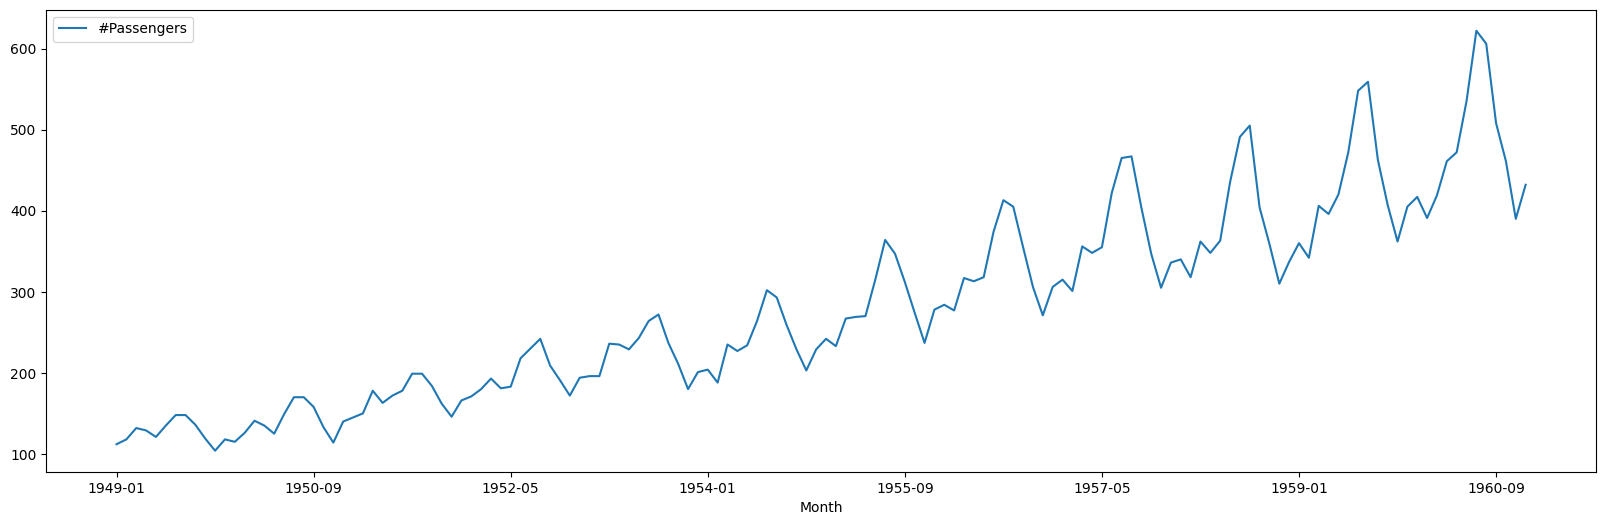

In [3]:
#Plot to visualize the time series data
df.plot(figsize=(20,6))
plt.show()

### Smoothing Models

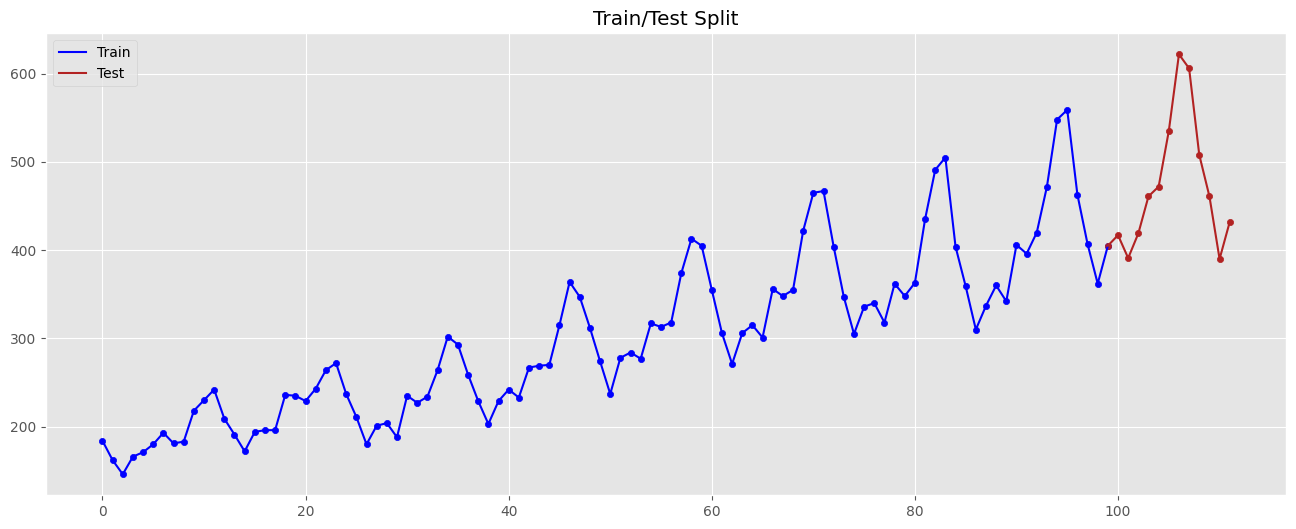

In [4]:
#Before fitting the models, split the data into training and testing;
#We will take the last year of data to test the results of the models
df_train = df.iloc[:-12]
df_test = df.iloc[-12:]

#Plot the data by calling plot_train_test_split() function from chronokit.utils module
from chronokit.utils import plot_train_test_split
#Take a smaller part of the training data to visualize the test data better
plot_train_test_split(train_data=df_train[-100:], test_data=df_test, figsize=(16,6), colors=["blue", "red"], style="ggplot", title="Train/Test Split")

In [5]:
#Import the ExponentialSmoothing model class
from chronokit.exponential_smoothing import ExponentialSmoothing

#Initialize the smoothing model
#Trend and seasonal arguments correspond to method of calceulation for the respective components
#We will try a seasonality period of 12, which corresponds to a year
#Different combinations of methods can be tried out to get better results
smoothing_model = ExponentialSmoothing(data=df_train, 
                                       trend="add", 
                                       seasonal="add", 
                                       seasonal_periods=12)

In [6]:
#Fit the smoothing model to the training data by calling .fit()
smoothing_model.fit()

#For forecasting, call the .predict() method with providing the forecasting horizon (h) as the argument
#Confidence of 0.95 returns probabilistic forecast limits for the horizon h, with confidence level of %95
fc, bounds = smoothing_model.predict(h=12, confidence=0.95)

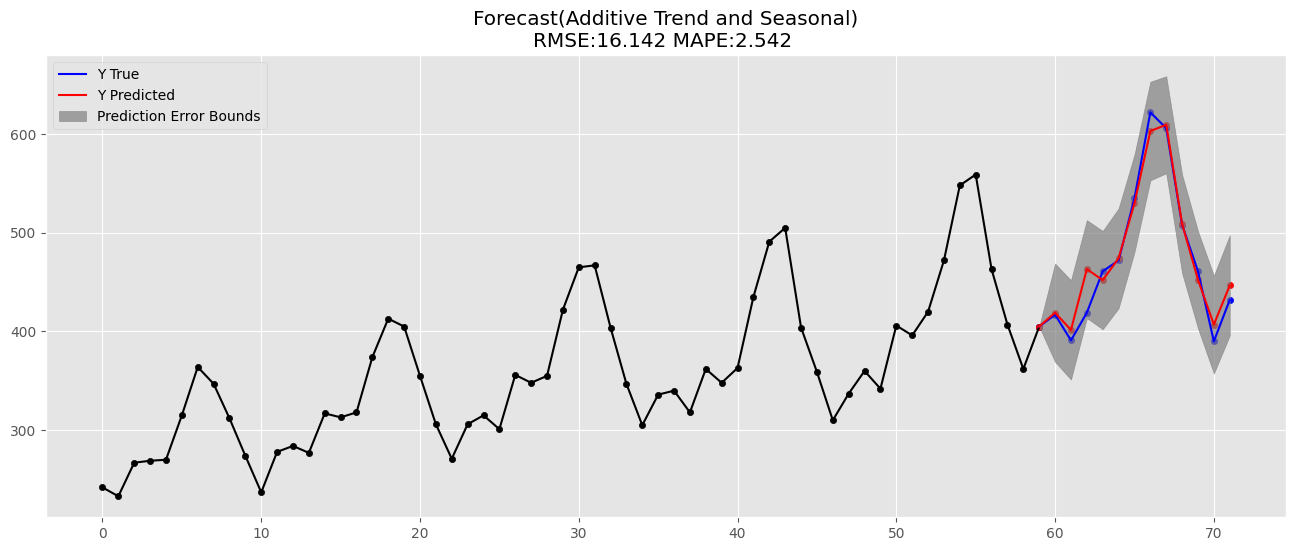

In [7]:
#Visualize the results by calling plot_predictions() from chronokit.utils module

from chronokit.utils import plot_predictions

#Provide the last 10 months of training data as pre_vals for a better visuals
#Provide metrics argument(as a list) to see the resulting metrics on the title
plot_predictions(y_true=df_test, y_pred=fc, pre_vals=df_train[-60:], colors=["blue", "red"], 
                 bounds=bounds, title="Forecast(Additive Trend and Seasonal)", 
                 metrics=["rmse", "mape"])

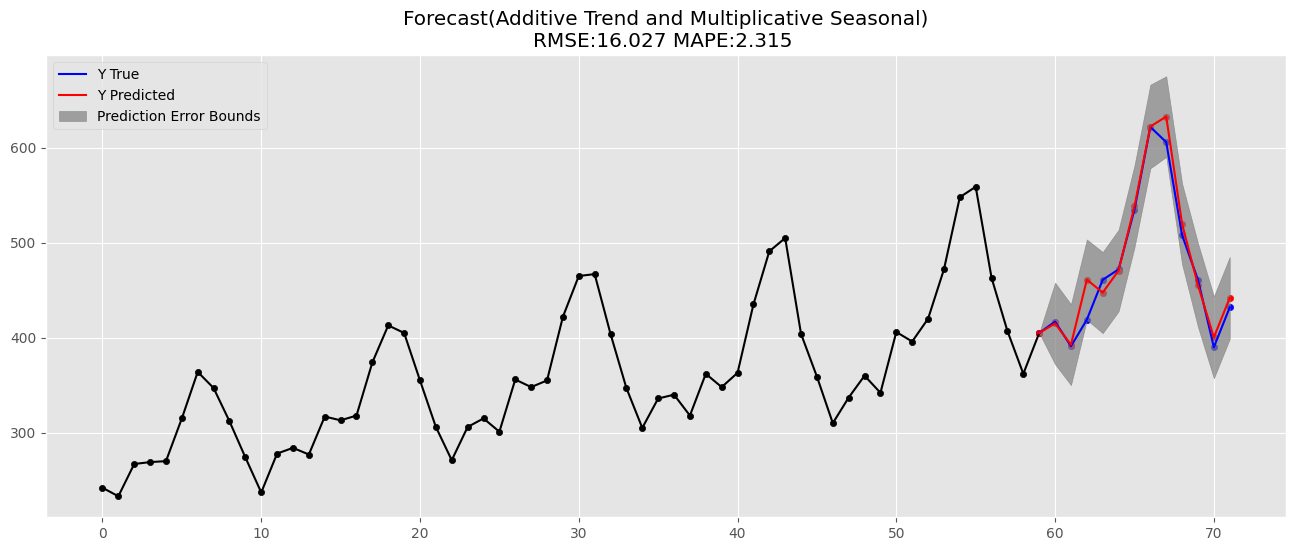

In [8]:
#Let's try multiplicative seasonality to see if we can get better results
#Take note that models with multiplicative components require strictly positive data
smoothing_model = ExponentialSmoothing(data=df_train, 
                                       trend="add", 
                                       seasonal="mul", 
                                       seasonal_periods=12)

#Now, let's see how the multiplicative seasonality performs
smoothing_model.fit()
fc, bounds = smoothing_model.predict(h=12, confidence=0.95)

#Results are somewhat better, but not by a large margin
plot_predictions(y_true=df_test, y_pred=fc, pre_vals=df_train[-60:], colors=["blue", "red"], 
                 bounds=bounds, title="Forecast(Additive Trend and Multiplicative Seasonal)", 
                 metrics=["rmse", "mape"])

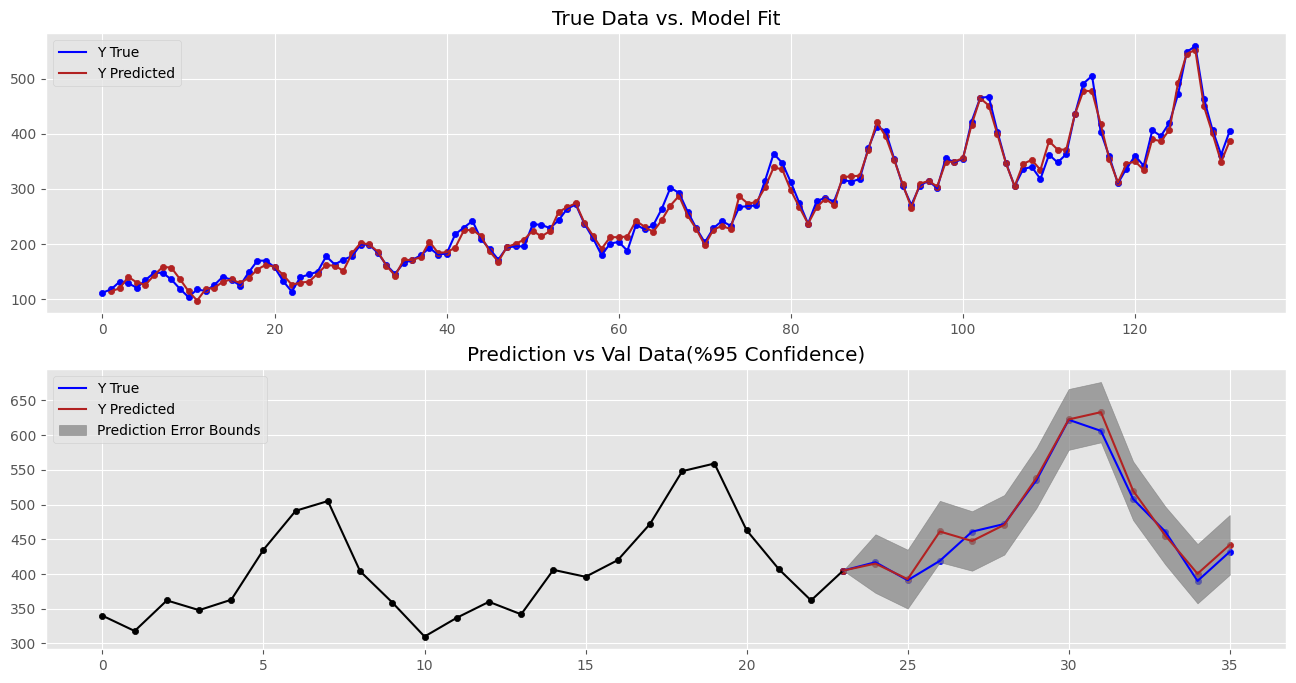

In [9]:
#It is also possible to evaluate the model's performance directly by calling .evaulate()
#2 Evaluation steps are performed;
#  1) Evaluate the model's fit to the training data by information criterions
#     * Information criterions basically measure how well the data fits to the data,
#       with taking number of parameters into consideration to acount for overfitting
#  2) Evaluate the model's performance on test data by regression metrics

#We'll use the rmse and mape metrics for evaluation on test data
#And Akaike Information Criterion for evaluating model fit
evaluation_results = smoothing_model.evaluate(df_test, 
                                              metrics=["rmse", "mape"],
                                              criterions=["aic"])

In [10]:
#We can see numerical results of the evaulation on the returned dataframe
evaluation_results

,Value
AIC,1005.972046
Val_RMSE,16.026901
Val_MAPE,2.315247


### ETS Models

##### ETS stands for Error-Trend-Seasonality and these types of models take the residuals generated during fitting into account when estimating components

In [11]:
#Import the ExponentialSmoothing model class
from chronokit.exponential_smoothing import ETS


#Initialize the ETS model
#Parameters are generally the same for smoothing models, 
#with error generated during fitting accounted for when updating state parameters

ets_model = ETS(data=df_train, 
                error_type="add",
                trend="add", 
                seasonal="mul", 
                seasonal_periods=12)

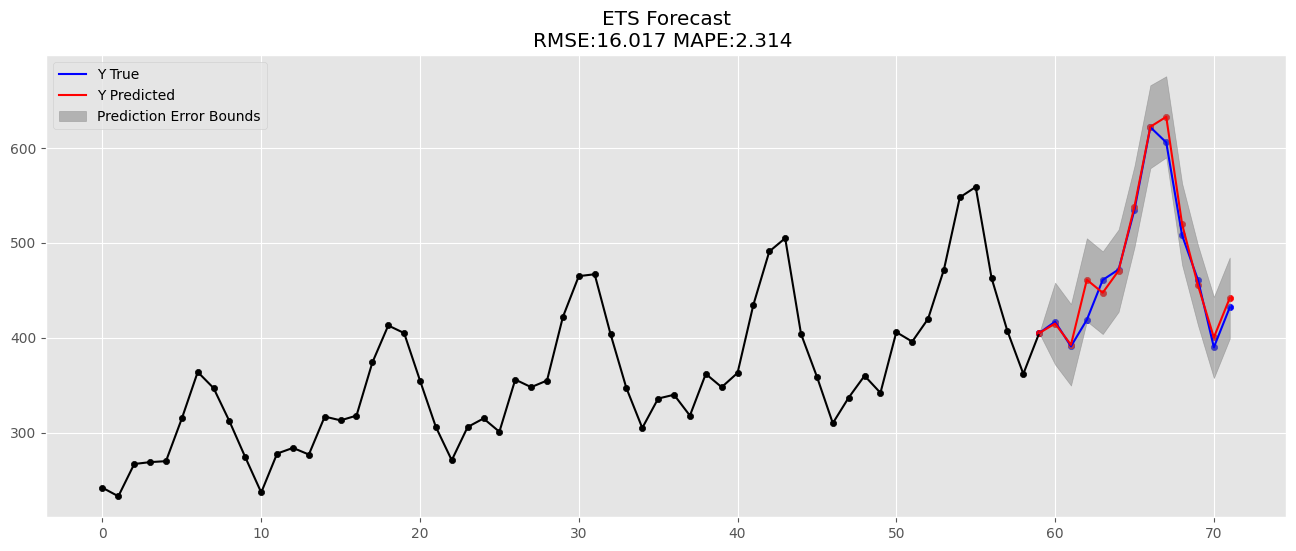

In [12]:
#Fit the smoothing model to the training data by calling .fit()
ets_model.fit()

#Same as the smoothing models, call .predict() by providing h and confidence if desired
fc, bounds = ets_model.predict(h=12, confidence=0.95)

#Plot the forecasts together with the confidence interval
plot_predictions(y_true=df_test, y_pred=fc, bounds=bounds, pre_vals=df_train[-60:], bounds_fill_alpha=0.5, 
                 colors=["blue", "red"], title="ETS Forecast", metrics=["rmse", "mape"])

### Model Selection

* The model selection process applies information criterions to estimate the best fitting model for the given data
* The procedure is as follows;
    1) Given a class of models, fit each model into the training data
    2) Evaluate performance during fitting according to chosen information criterions
    3) Generate forecasts with the models, and evaluate forecast accuracy according to chosen metrics
    4) Rank the models according to their performance

In [13]:
#Import the model_selection() function
from chronokit.utils.evaluation import ModelEvaluator

In [14]:
#Provide the scaled data to also include multiplicative seasonality models
#Provide model="smoothing" to compare exponential smoothing models

#By providing three metrics and one criterion, we put more emphasis on performance on validation data
evaluator = ModelEvaluator(eval_metrics=["rmse", "mape", "mae"],
                           criterions=["aic"])
#Get the selection results and the recommended parameters
results, rankings = evaluator.run_model_selection(df_train, model_type="smoothing",
                                                  val_data=df_test,
                                                  seasonal_periods=12,
                                                  smoothing_args={"error": ["add", "mul"],
                                                                  "damped": [False],
                                                                  "seasonal": ["add", "mul"]})

#Lower values imply better results
results

Evaluating parameters for smoothing models...
Best Model: ETS(M, A, M)


,AIC,Val_RMSE,Val_MAPE,Val_MAE
"ETS(A, N, A)",1038.589478,24.624071,4.483486,21.568968
"ETS(A, N, M)",1008.550232,22.781397,4.417406,20.690283
"ETS(A, M, A)",1034.419189,18.194757,3.034546,13.566533
"ETS(A, M, M)",1000.837463,19.334158,2.958859,13.884685
"ETS(A, A, A)",1046.836060,16.140759,2.541413,11.379560
"ETS(A, A, M)",1005.978455,16.017166,2.313730,10.738353
"ETS(M, N, A)",1038.579468,24.626322,4.483975,21.571648
"ETS(M, N, M)",1008.550232,22.781397,4.417406,20.690283
"ETS(M, M, A)",1034.407471,18.228121,3.041171,13.591992
"ETS(M, M, M)",1001.041016,20.258194,3.191807,15.051227


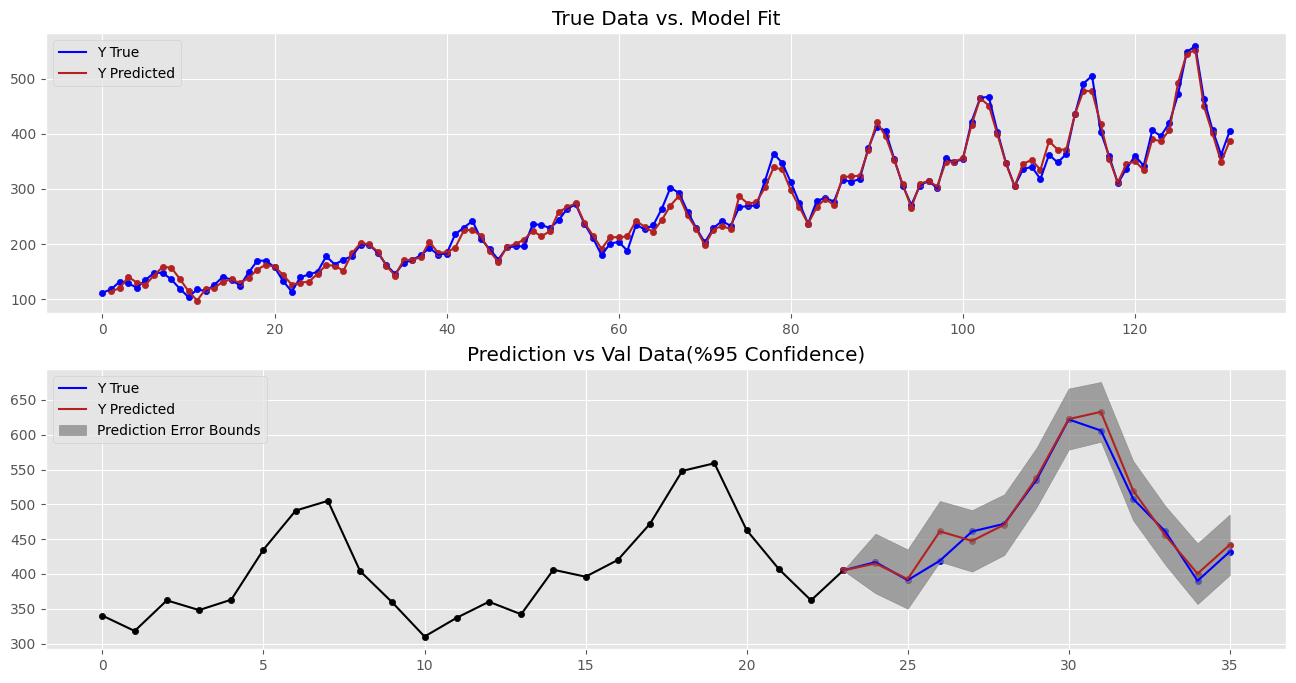

In [15]:
#Fit the ETS model
best_ets = ETS(data=df_train, error_type="mul", trend="add", seasonal="mul", seasonal_periods=12)
best_ets.fit()

evaluation_results = best_ets.evaluate(df_test, metrics=["rmse", "mape","mae"], criterions=["aic"])

In [16]:
evaluation_results

,Value
AIC,1005.970459
Val_RMSE,16.012184
Val_MAPE,2.312754
Val_MAE,10.733035


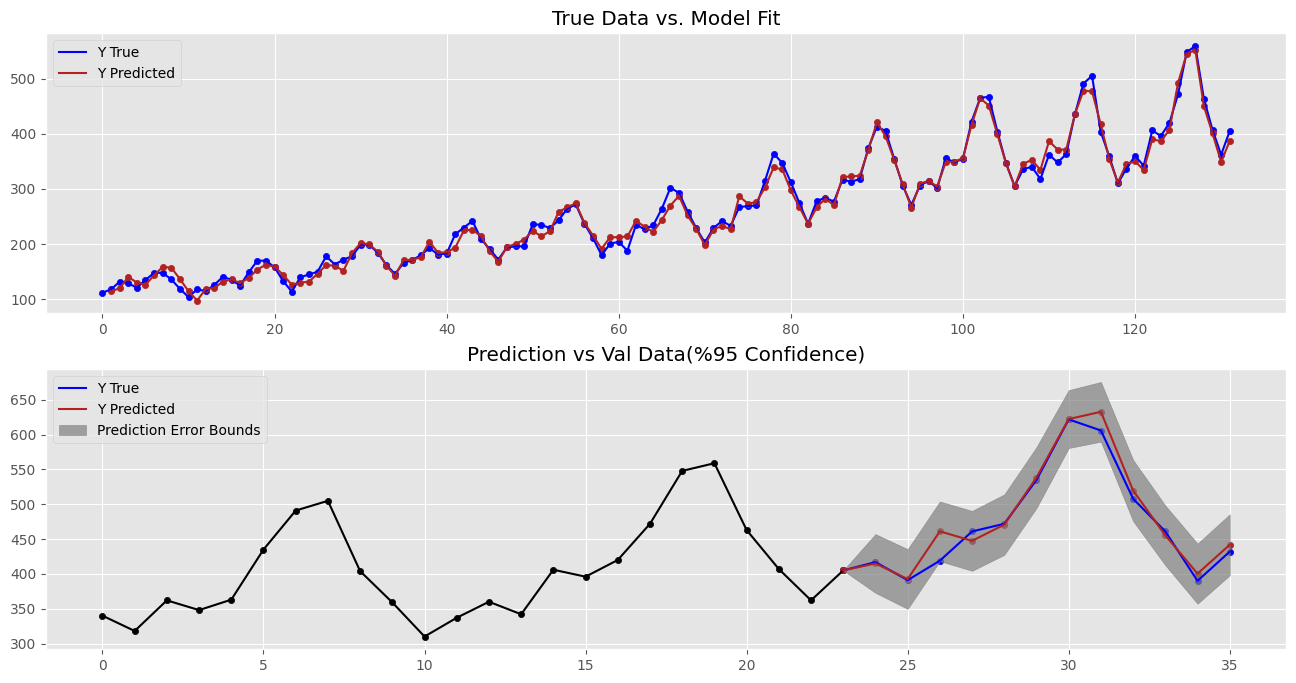

In [17]:
#Fit the ETS model
best_ets = ETS(data=df_train, error_type="mul", trend="add", seasonal="mul", seasonal_periods=12)
best_ets.fit()

evaluation_results = best_ets.evaluate(df_test, metrics=["mape", "rmse"], criterions=["aic"])

In [18]:
evaluation_results

,Value
AIC,1005.970459
Val_MAPE,2.312754
Val_RMSE,16.012184
